The training is done in three stages:  
1) Train on all data, we need to get the error to be less than 1.9.
2) Based on the sentence corpus, the best solution is calculated using validation data. Polishing the model.
3) Based on the corpus with 5 sentences (or paragraphs), the best solution is calculated using validation data. To teach nllb-200 to handle multiple sentences.

And then the best model is selected based on the metrics: ChRF++ and Blue

# 1.Libraries -----------------------------

In [ ]:
!pip install sentencepiece==0.1.99 transformers==4.33.2 datasets sacremoses sacrebleu  -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 9.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 24.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.6/519.6 kB 22.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 880.6/880.6 kB 26.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 118.9/118.9 kB 13.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.0/302.0 kB 23.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 51.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 31.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 13.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 16.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 16.0 MB/s eta 0:00:00


In [ ]:
import os
import json
import random
import torch
import nltk
import gc
import unicodedata
import re
import sys
import typing as tp
import numpy as np
import pandas as pd
import sacrebleu
from sacremoses import MosesPunctNormalizer
from transformers import AutoModelForSeq2SeqLM, NllbTokenizer
from transformers.optimization import Adafactor
from transformers import get_constant_schedule_with_warmup
from tqdm.auto import tqdm, trange

# 2.CONSTANTS -----------------------------

In [ ]:
from google.colab import drive
drive.mount('/Til')

Mounted at /Til


In [ ]:
PATH = '/Til/MyDrive/Colab Notebooks/Til/'
DATA_PATH = "".join([PATH, 'Data/'])
ALL_SENTENCES_PATH     = "".join([DATA_PATH, 'All_model.csv'])
ONE_SENTENCE_PATH      = "".join([DATA_PATH, 'One_sentence_model.csv'])
SEVERAL_SENTENCES_PATH = "".join([DATA_PATH, 'Several_sentence_model.csv'])

MODEL_PATH = "".join([PATH, 'models/NLLB_v1/'])

MODEL_PATH_RAW = "".join([MODEL_PATH, 'nllb_krc_raw'])
MODEL_PATH_QM_ALL = "".join([MODEL_PATH, 'nllb_qm_v1_all'])
MODEL_PATH_QM_ONE = "".join([MODEL_PATH, 'nllb_qm_v1_one'])
MODEL_PATH_QM_SEV = "".join([MODEL_PATH, 'nllb_qm_v1_sev'])

LANG_UNICODE = 'krc_Cyrl'
SRC_LANG = "krc_Cyrl"
TRG_LANG = "rus_Cyrl"

SHARE_VAL = 0.25
SHARE_TEST = 0.05

MAX_LENGTH = 256 # 512

SRC_LANG_DF = SRC_LANG.removesuffix("_Cyrl")
TRG_LANG_DF = TRG_LANG.removesuffix("_Cyrl")

LANGS = [(TRG_LANG_DF, TRG_LANG), (SRC_LANG_DF, SRC_LANG)]

# 3.LOAD MODEL -----------------------------

In [ ]:
tokenizer = NllbTokenizer.from_pretrained(MODEL_PATH_RAW) # MODEL_PATH_RAW
model = AutoModelForSeq2SeqLM.from_pretrained(MODEL_PATH_RAW) # MODEL_PATH_RAW

if torch.cuda.is_available():
    model.cuda()

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [ ]:
bleu_calc = sacrebleu.BLEU()
chrf_calc = sacrebleu.CHRF(word_order=2)  # this metric is called ChrF++

# 4.LOAD DATASETS -----------------------------

In [ ]:
all_sentences = pd.read_csv(ALL_SENTENCES_PATH, sep = ';')
one_sentence = pd.read_csv(ONE_SENTENCE_PATH, sep = ';')
several_sentences = pd.read_csv(SEVERAL_SENTENCES_PATH, sep = ';')

In [ ]:
def splitDataset(df):
  num_test_samples = round(SHARE_TEST * len(df))
  num_val_samples = round(SHARE_VAL * len(df))
  num_train_samples = len(df) - num_val_samples - num_test_samples

  vec_types = ["train"] * num_train_samples + ["test"] * num_test_samples +  ["val"] * num_val_samples
  pair_group = random.sample(vec_types, len(vec_types))

  test_pairs = df[[(a == "test") for a in pair_group]]
  train_pairs = df[[(a == "train") for a in pair_group]]
  valid_pairs = df[[(a == "val") for a in pair_group]]

  return (train_pairs, valid_pairs, test_pairs)

In [ ]:
train_all_sentences = all_sentences
train_all, valid_all, test_all = splitDataset(df = all_sentences)
train_one, valid_one, test_one = splitDataset(df = one_sentence)
train_sev, valid_sev, test_sev = splitDataset(df = several_sentences)

In [ ]:
train_all[:10]

,krc,rus
2,- Некди теnиз былай тузлу? – деb сейирсинnенди.,- Почему вода такая солёная? – он поинтересова...
3,Анасы jашына теnизни хапарын айтханды:,Мама мальчика о море начала говорить:
4,- Эртде-эртде бир бай qарнаш бла бир jарлы qар...,- Давным-давно жили один богатый брат и один б...
6,- Не айланаса? – деb сорgан кишичик.,- Ты бродяга? – спросил мужчина.
7,"Jаш аnа, былай да былай деb, jарлылыq хапарын ...","Парень Бедняк ему, так и так – бедность - расс..."
8,"- Ма, бу гырjынчыqны ал да, таw артына бар. Ан...","- На, это кусок хлеба возьми и за гору иди. Т..."
10,- Бизге бер! – деb ала муну гырjынчыgын бир аw...,- Нам дай! – они хлеба попросили.
12,"- Айт, не дей эсеn да, берейик, - дегендиле ги...","- Говори, что на уме у тебя, даем, - сказали м..."
14,"Jарлы qарнаш, тирменни да алыb, юйюне qайтыb к...","Бедный брат, взяв мельницу, домой принёс. Но т..."
17,Тебрегенди тирменчик да тохтаwсуз туз чыgарыb....,"Раскрутил мельницу, что оттуда безостановочно ..."


# 5.PREPARING TOKENIZER -----------------------------

Because language ids are added by hard-code on initialization, we need to manually fix them.

In [ ]:
def fix_tokenizer(tokenizer, new_lang=LANG_UNICODE):
    """
    Add a new language token to the tokenizer vocabulary
    (this should be done each time after its initialization)
    """
    old_len = len(tokenizer) - int(new_lang in tokenizer.added_tokens_encoder)
    tokenizer.lang_code_to_id[new_lang] = old_len-1
    tokenizer.id_to_lang_code[old_len-1] = new_lang
    # always move "mask" to the last position
    tokenizer.fairseq_tokens_to_ids["<mask>"] = len(tokenizer.sp_model) + len(tokenizer.lang_code_to_id) + tokenizer.fairseq_offset

    tokenizer.fairseq_tokens_to_ids.update(tokenizer.lang_code_to_id)
    tokenizer.fairseq_ids_to_tokens = {v: k for k, v in tokenizer.fairseq_tokens_to_ids.items()}
    if new_lang not in tokenizer._additional_special_tokens:
        tokenizer._additional_special_tokens.append(new_lang)
    # clear the added token encoder; otherwise a new token may end up there by mistake
    tokenizer.added_tokens_encoder = {}
    tokenizer.added_tokens_decoder = {}

In [ ]:
fix_tokenizer(tokenizer)

Checking

In [ ]:
print(tokenizer.convert_ids_to_tokens([262923, 262924, 262925])) # ['zul_Latn', 'krc_Cyrl', '<mask>']
print(tokenizer.convert_tokens_to_ids(['zul_Latn', 'krc_Cyrl', '<mask>'])) # [262923, 262924, 262925]

['zul_Latn', 'krc_Cyrl', '<mask>']
[262923, 262924, 262925]


In [ ]:
for token_id in range(len(tokenizer.sp_model), len(tokenizer)):
    token = tokenizer.convert_ids_to_tokens(token_id)
    print(token_id, token)

# 6.FUNCTIONS -----------------------------

### 6.1.PREPROC -----------------------------

In [ ]:
mpn = MosesPunctNormalizer(lang="en")
mpn.substitutions = [
    (re.compile(r), sub) for r, sub in mpn.substitutions
]


def get_non_printing_char_replacer(replace_by: str = " ") -> tp.Callable[[str], str]:
    non_printable_map = {
        ord(c): replace_by
        for c in (chr(i) for i in range(sys.maxunicode + 1))
        # same as \p{C} in perl
        # see https://www.unicode.org/reports/tr44/#General_Category_Values
        if unicodedata.category(c) in {"C", "Cc", "Cf", "Cs", "Co", "Cn"}
    }

    def replace_non_printing_char(line) -> str:
        return line.translate(non_printable_map)

    return replace_non_printing_char

replace_nonprint = get_non_printing_char_replacer(" ")

def preproc(text):
    clean = mpn.normalize(text)
    clean = replace_nonprint(clean)
    # replace 𝓕𝔯𝔞𝔫𝔠𝔢𝔰𝔠𝔞 by Francesca
    clean = unicodedata.normalize("NFKC", clean)
    return clean

### 6.2. OTHER -----------------------------

In [ ]:
def cleanup():
    """Try to free GPU memory"""
    gc.collect()
    torch.cuda.empty_cache()

def getBatchPairs(batch_size, data, step=None):

    (l1, long1), (l2, long2) = random.sample(LANGS, 2)
    xx, yy = [], []
    if step == None:
      for _ in range(batch_size):
        item = data.iloc[random.randint(0, len(data)-1)]
        xx.append(preproc(item[l1]))
        yy.append(preproc(item[l2]))
    else:
      batch_data = data[step * batch_size: (step + 1) * batch_size]
      xx=preproc(batch_data[l1].to_list())
      yy=preproc(batch_data[l2].to_list())

    return xx, yy, long1, long2

print(getBatchPairs(4, data=train_all_sentences, step=4))

("['Аны тирменчигин урлаb, qача барыb, кете тебреb турgан уллу кемеге минnенди да, башлаgанды тирменчикден хар нени да бирден тилеb, qаты буруb.', 'Тебрегенди тирменчик да тохтаwсуз туз чыgарыb. Туз кемеге сыйынмай, теnизге qуюла башлаgанды. Qуюл да qуюл! Бир заманда боран qобханды. Туз jюгюн кючден кёлтюрюb jюзген кеме, jут qарнашны да биргесине ала, теnизге батханды да кетгенди.', 'Тирменчик а бюгюн да теnизни тюбюнде тохтаwсуз кесини ичинден туз чыgарыb кюрешеди, дейдиле. Ол туз а эриb, тиnизни тузлу этгенлей турады.', 'Бешjыллыq jашчыqны аqыллылыgыда.']", "['Его мельницу украв, убежав, направляясь к кораблю верхом, одновременно начал всё у мельницы просить, сильно крутя её.', 'Раскрутил мельницу, что оттуда безостановочно соль выходила. Соль на корабль не вмещалась, в море высыпаться начала. Высыпалась и высыпалась! В один момент буран поднялся. Соль едва поднялась и начала плавать на корабле, и вместе с алчным братом, в море утонуло.', 'А мельница сегодня также на дне моря безоста

### 6.3.TRAIN FUNCTION -----------------------------

* batch_size                - Size of batch
* checkpoint_steps          - After how many iterations to check and report
* n_non_improve_val_perplex - Number of subsequent training checkpoints if there are no improvements in validation perplexity
* val_amount_test           - Number of tests for validation
* steps                     - Number of steps for training
* data_train                - Train dataset
* data_validation           - Validation dataset
* model_path                - Path to save model
* random_batch              - Is it need to train all data or random one?  
You need to initialize: losses and val_losses - they are the global variable

In [ ]:
def trainModel(batch_size, checkpoint_steps, steps, data_train, model_path, data_validation=None, n_non_improve_val_perplex=None, val_amount_test=None, random_batch=True):
  train_data = data_train.sample(frac = 1)
  x, y, loss, loss_val  = None, None, None, None
  last_val_best_loss_perpl = float("Inf")
  improve_iter = 0

  tq = trange(len(losses), steps)
  for i in tq:
    if random_batch == True:
      xx, yy, lang1, lang2 = getBatchPairs(batch_size, data = train_data)
    else:
      xx, yy, lang1, lang2 = getBatchPairs(batch_size, data = train_data, step=i)

    try:
        tokenizer.src_lang = lang1
        x = tokenizer(xx, return_tensors='pt', padding=True, truncation=True, max_length=MAX_LENGTH).to(model.device)
        tokenizer.src_lang = lang2
        y = tokenizer(yy, return_tensors='pt', padding=True, truncation=True, max_length=MAX_LENGTH).to(model.device)
        y.input_ids[y.input_ids == tokenizer.pad_token_id] = -100

        loss = model(**x, labels=y.input_ids).loss
        loss.backward()
        losses.append(loss.item())

        optimizer.step()
        optimizer.zero_grad(set_to_none=True)
        scheduler.step()

    except RuntimeError as e:
        optimizer.zero_grad(set_to_none=True)
        x, y, loss = None, None, None
        cleanup()
        print('error', max(len(s) for s in xx + yy), e)
        continue

    if i % checkpoint_steps == 0:
      # if (data_validation != None) & (n_non_improve_val_perplex != None) & (val_amount_test != None):
      if (n_non_improve_val_perplex != None) & (val_amount_test != None):
        for _ in range(0, val_amount_test):
          xx, yy, lang1, lang2 = getBatchPairs(batch_size, data = data_validation)

          try:
            tokenizer.src_lang = lang1
            x_val = tokenizer(xx, return_tensors='pt', padding=True, truncation=True, max_length=MAX_LENGTH).to(model.device)
            tokenizer.src_lang = lang2
            y_val = tokenizer(yy, return_tensors='pt', padding=True, truncation=True, max_length=MAX_LENGTH).to(model.device)
            y.input_ids[y.input_ids == tokenizer.pad_token_id] = -100

            loss_val = model(**x_val, labels=y_val.input_ids).loss
            val_losses.append(loss_val.item())

          except RuntimeError as e:
            optimizer.zero_grad(set_to_none=True)
            x, y, loss, loss_val  = None, None, None, None
            cleanup()
            print('error', max(len(s) for s in xx + yy), e)
            continue

        train_loss = np.mean(losses[-checkpoint_steps:])
        train_perp = np.mean(np.exp(losses[-checkpoint_steps:]))
        val_loss = np.mean(val_losses[-val_amount_test:])
        val_perp = np.mean(np.exp(val_losses[-val_amount_test:]))
        # val_blue = np.mean(blue_val)
        # val_chrf = np.mean(chrf_losses)

        print('Step:', i, '/', steps, '; loss:', train_loss, '; validation loss:', val_loss,'; perplexity:', train_perp, '; validation perplexity:', val_perp)


        # Update control values and save best result
        if val_perp < last_val_best_loss_perpl:
          last_val_best_loss_perpl = val_perp
          improve_iter = i
          print('Save model')
          # model.save_pretrained(model_path, force_download=True)
          # tokenizer.save_pretrained(model_path, force_download=True)
          model.save_pretrained(model_path)
          tokenizer.save_pretrained(model_path)

        # Stop cycle
        if (i - improve_iter) >= (n_non_improve_val_perplex * checkpoint_steps):
          print('Break')
          break

      else:
        train_loss = np.mean(losses[-checkpoint_steps:])
        train_perp = np.mean(np.exp(losses[-checkpoint_steps:]))
        print('Step:', i, '/', steps, '; loss:', train_loss, '; perplexity:', train_perp)

        model.save_pretrained(model_path)
        tokenizer.save_pretrained(model_path)

# 7.TRAIN -----------------------------

In [ ]:
optimizer = Adafactor(
    [p for p in model.parameters() if p.requires_grad],
    scale_parameter=False,
    relative_step=False,
    lr=1e-4,
    clip_threshold=1.0,
    weight_decay=1e-3,
)

scheduler = get_constant_schedule_with_warmup(optimizer, num_warmup_steps=1000)

model.train()

M2M100ForConditionalGeneration(
  (model): M2M100Model(
    (shared): Embedding(262926, 1024, padding_idx=1)
    (encoder): M2M100Encoder(
      (embed_tokens): Embedding(262926, 1024, padding_idx=1)
      (embed_positions): M2M100SinusoidalPositionalEmbedding()
      (layers): ModuleList(
        (0-11): 12 x M2M100EncoderLayer(
          (self_attn): M2M100Attention(
            (k_proj): Linear(in_features=1024, out_features=1024, bias=True)
            (v_proj): Linear(in_features=1024, out_features=1024, bias=True)
            (q_proj): Linear(in_features=1024, out_features=1024, bias=True)
            (out_proj): Linear(in_features=1024, out_features=1024, bias=True)
          )
          (self_attn_layer_norm): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
          (activation_fn): ReLU()
          (fc1): Linear(in_features=1024, out_features=4096, bias=True)
          (fc2): Linear(in_features=4096, out_features=1024, bias=True)
          (final_layer_norm): LayerNorm

### 7.1.TRAIN ALL -----------------------------

Here we need to get the error to be less than 1.9, so run one to several times

In [ ]:
batch_size = 32 # 2
checkpoint_steps = 500 # 1
n_non_improve_val_perplex = 7 # Number of subsequent training checkpoints if there is no improvement in validation perplexity
val_amount_test = 10 # Number of tests for validation
epoches = 3


  0%|          | 0/1 [00:00<?, ?it/s]

epoch  0


  0%|          | 0/8143 [00:00<?, ?it/s]

Step: 0 / 8143 ; loss: 1.9660922288894653 ; perplexity: 7.14270980520984
Step: 500 / 8143 ; loss: 1.9038795385360718 ; perplexity: 7.081068113140006
Step: 1000 / 8143 ; loss: 1.9434313554763794 ; perplexity: 7.355096908864842
Step: 1500 / 8143 ; loss: 1.9123299318552016 ; perplexity: 7.147991868611456
Step: 2000 / 8143 ; loss: 1.9194632617235183 ; perplexity: 7.203711816721094
Step: 2500 / 8143 ; loss: 1.9350207946300506 ; perplexity: 7.284755713771838
Step: 3000 / 8143 ; loss: 1.896947075843811 ; perplexity: 7.032689446129894
Step: 3500 / 8143 ; loss: 1.9145217344760894 ; perplexity: 7.1896628550676285
Step: 4000 / 8143 ; loss: 1.895232275724411 ; perplexity: 6.971440705039739
Step: 4500 / 8143 ; loss: 1.8984998137950897 ; perplexity: 7.0070252944748574
Step: 5000 / 8143 ; loss: 1.8832742087841035 ; perplexity: 6.933646197035579
Step: 5500 / 8143 ; loss: 1.9046634123325348 ; perplexity: 7.009283815764313
Step: 6000 / 8143 ; loss: 1.9120640919208527 ; perplexity: 7.187285280390498
Step

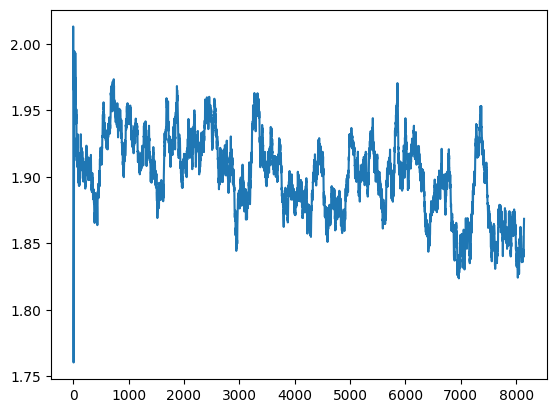

In [ ]:
for i in trange(0, epoches):
  print("epoch ", i, "/", epoches)
  losses = []
  val_losses = []
  trainModel(batch_size                = batch_size,
             checkpoint_steps          = checkpoint_steps,
             steps                     = int(len(train_all_sentences) / batch_size),
             # steps                     = 10,
             data_train                = train_all_sentences,
             model_path                = MODEL_PATH_QM_ALL,
             data_validation           = None,
             n_non_improve_val_perplex = None,
             val_amount_test           = None,
             random_batch              = False)


pd.Series(losses).ewm(100).mean().plot();

### 7.3.TRAINING ONE -----------------------------


In [ ]:
cleanup()

In [ ]:
tokenizer = NllbTokenizer.from_pretrained(MODEL_PATH_QM_ALL) # MODEL_PATH_RAW
model = AutoModelForSeq2SeqLM.from_pretrained(MODEL_PATH_QM_ALL) # MODEL_PATH_RAW

if torch.cuda.is_available():
    model.cuda()

fix_tokenizer(tokenizer)
print(tokenizer.convert_ids_to_tokens([262923, 262924, 262925])) # ['zul_Latn', 'krc_Cyrl', '<mask>']
print(tokenizer.convert_tokens_to_ids(['zul_Latn', 'krc_Cyrl', '<mask>'])) # [262923, 262924, 262925]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


['zul_Latn', 'krc_Cyrl', '<mask>']
[262923, 262924, 262925]


In [ ]:
optimizer = Adafactor(
    [p for p in model.parameters() if p.requires_grad],
    scale_parameter=False,
    relative_step=False,
    lr=1e-4,
    clip_threshold=1.0,
    weight_decay=1e-3,
)

scheduler = get_constant_schedule_with_warmup(optimizer, num_warmup_steps=1000)

model.train()

M2M100ForConditionalGeneration(
  (model): M2M100Model(
    (shared): Embedding(262926, 1024, padding_idx=1)
    (encoder): M2M100Encoder(
      (embed_tokens): Embedding(262926, 1024, padding_idx=1)
      (embed_positions): M2M100SinusoidalPositionalEmbedding()
      (layers): ModuleList(
        (0-11): 12 x M2M100EncoderLayer(
          (self_attn): M2M100Attention(
            (k_proj): Linear(in_features=1024, out_features=1024, bias=True)
            (v_proj): Linear(in_features=1024, out_features=1024, bias=True)
            (q_proj): Linear(in_features=1024, out_features=1024, bias=True)
            (out_proj): Linear(in_features=1024, out_features=1024, bias=True)
          )
          (self_attn_layer_norm): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
          (activation_fn): ReLU()
          (fc1): Linear(in_features=1024, out_features=4096, bias=True)
          (fc2): Linear(in_features=4096, out_features=1024, bias=True)
          (final_layer_norm): LayerNorm

In [ ]:
losses = []
val_losses = []

batch_size = 16 # 2
checkpoint_steps = 1000 # 1
n_non_improve_val_perplex = 28 # Number of subsequent training checkpoints if there is no improvement in validation perplexity
val_amount_test = 50 # Number of tests for validation
multiplicator = 12

  0%|          | 0/20128 [00:00<?, ?it/s]

Step: 0 / 20128 ; loss: 1.2348651885986328 ; validation loss: 12.380459232330322 ; perplexity: 3.4379150193216548 ; validation perplexity: 582120.541574274
Save model
Step: 1000 / 20128 ; loss: 0.9017644890844821 ; validation loss: 11.306512546539306 ; perplexity: 2.5228320463464944 ; validation perplexity: 143162.61577191018
Save model
Step: 2000 / 20128 ; loss: 0.8773691241443157 ; validation loss: 11.608137836456299 ; perplexity: 2.4572720926954874 ; validation perplexity: 172538.6328123204
Step: 3000 / 20128 ; loss: 0.843827339798212 ; validation loss: 11.428176746368408 ; perplexity: 2.371274734808918 ; validation perplexity: 175145.78569999372
Step: 4000 / 20128 ; loss: 0.8220828254818916 ; validation loss: 11.035327091217042 ; perplexity: 2.3255457260300867 ; validation perplexity: 108403.35424953226
Save model
Step: 5000 / 20128 ; loss: 0.7823721331059933 ; validation loss: 11.194899864196778 ; perplexity: 2.228446814865343 ; validation perplexity: 191673.81153965314
Step: 6000

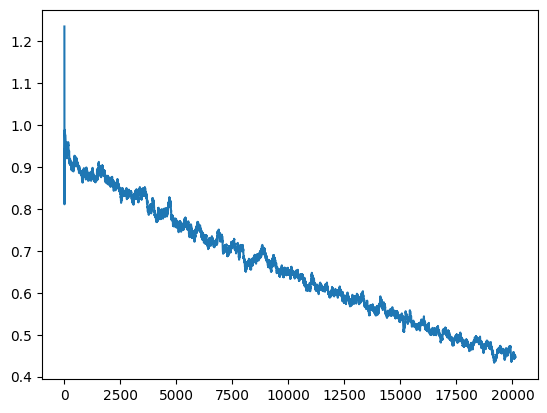

In [ ]:
trainModel(batch_size                = batch_size,
           checkpoint_steps          = checkpoint_steps,
           n_non_improve_val_perplex = n_non_improve_val_perplex, # Number of subsequent training checkpoints if there is no improvement in validation perplexity
           val_amount_test           = val_amount_test, # Number of tests for validation
           # steps                     = 10,
           steps                     = int(len(train_one) / batch_size) * multiplicator,
           data_train                = train_one,
           data_validation           = valid_one,
           model_path                = MODEL_PATH_QM_ONE,
           random_batch              = True)


pd.Series(losses).ewm(100).mean().plot();

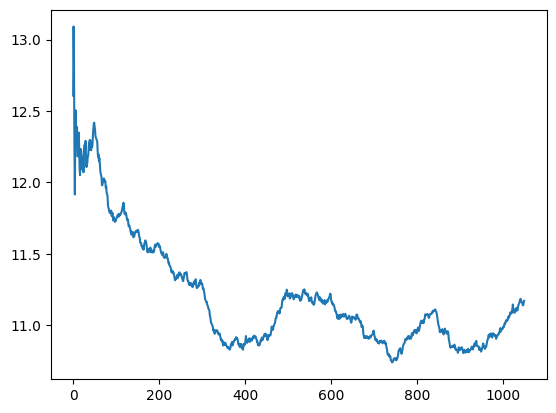

In [ ]:
pd.Series(val_losses).ewm(100).mean().plot();

In [ ]:
tokenizer.save_pretrained(MODEL_PATH_QM_ONE)
model.save_pretrained(MODEL_PATH_QM_ONE)

### 7.4.TRAINING SEVERAL -----------------------------

In [ ]:
cleanup()

In [ ]:
tokenizer = NllbTokenizer.from_pretrained(MODEL_PATH_QM_ONE) # MODEL_PATH_RAW
model = AutoModelForSeq2SeqLM.from_pretrained(MODEL_PATH_QM_ONE) # MODEL_PATH_RAW

if torch.cuda.is_available():
    model.cuda()

fix_tokenizer(tokenizer)
print(tokenizer.convert_ids_to_tokens([262923, 262924, 262925])) # ['zul_Latn', 'krc_Cyrl', '<mask>']
print(tokenizer.convert_tokens_to_ids(['zul_Latn', 'krc_Cyrl', '<mask>'])) # [262923, 262924, 262925]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


['zul_Latn', 'krc_Cyrl', '<mask>']
[262923, 262924, 262925]


In [ ]:
optimizer = Adafactor(
    [p for p in model.parameters() if p.requires_grad],
    scale_parameter=False,
    relative_step=False,
    lr=1e-4,
    clip_threshold=1.0,
    weight_decay=1e-3,
)

scheduler = get_constant_schedule_with_warmup(optimizer, num_warmup_steps=1000)

model.train()

M2M100ForConditionalGeneration(
  (model): M2M100Model(
    (shared): Embedding(262926, 1024, padding_idx=1)
    (encoder): M2M100Encoder(
      (embed_tokens): Embedding(262926, 1024, padding_idx=1)
      (embed_positions): M2M100SinusoidalPositionalEmbedding()
      (layers): ModuleList(
        (0-11): 12 x M2M100EncoderLayer(
          (self_attn): M2M100Attention(
            (k_proj): Linear(in_features=1024, out_features=1024, bias=True)
            (v_proj): Linear(in_features=1024, out_features=1024, bias=True)
            (q_proj): Linear(in_features=1024, out_features=1024, bias=True)
            (out_proj): Linear(in_features=1024, out_features=1024, bias=True)
          )
          (self_attn_layer_norm): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
          (activation_fn): ReLU()
          (fc1): Linear(in_features=1024, out_features=4096, bias=True)
          (fc2): Linear(in_features=4096, out_features=1024, bias=True)
          (final_layer_norm): LayerNorm

In [ ]:
losses = []
val_losses = []

In [ ]:
batch_size = 8 # 2
checkpoint_steps = 500 # 1
n_non_improve_val_perplex = 16 # Number of subsequent training checkpoints if there is no improvement in validation perplexity
val_amount_test = 50 # Number of tests for validation
multiplicator = 8

  0%|          | 0/4168 [00:00<?, ?it/s]

Step: 0 / 4168 ; loss: 0.4571554958820343 ; validation loss: 9.235904722213744 ; perplexity: 1.5795744824815816 ; validation perplexity: 22005.860061041607
Save model
Step: 500 / 4168 ; loss: 0.5535339382886887 ; validation loss: 8.240299978256225 ; perplexity: 1.7721617839814015 ; validation perplexity: 8473.18029219669
Save model
Step: 1000 / 4168 ; loss: 0.4826882789134979 ; validation loss: 8.584512453079224 ; perplexity: 1.6458273131412497 ; validation perplexity: 12024.880017198771
Step: 1500 / 4168 ; loss: 0.4492411629259586 ; validation loss: 8.504578800201417 ; perplexity: 1.5932398338531661 ; validation perplexity: 9810.724474110817
Step: 2000 / 4168 ; loss: 0.40831055365502833 ; validation loss: 9.647112007141112 ; perplexity: 1.53055237995154 ; validation perplexity: 53585.410255662966
Step: 2500 / 4168 ; loss: 0.3641629644334316 ; validation loss: 9.69720067024231 ; perplexity: 1.458705261174111 ; validation perplexity: 55379.07346237168
Step: 3000 / 4168 ; loss: 0.3311686

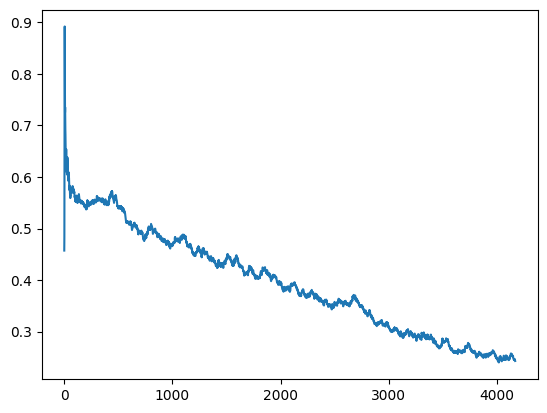

In [ ]:
trainModel(batch_size                = batch_size,
           checkpoint_steps          = checkpoint_steps,
           n_non_improve_val_perplex = n_non_improve_val_perplex, # Number of subsequent training checkpoints if there is no improvement in validation perplexity
           val_amount_test           = val_amount_test, # Number of tests for validation
           # steps                     = 10,
           steps                     = int(len(train_sev) / batch_size) * multiplicator,
           data_train                = train_sev,
           data_validation           = valid_sev,
           model_path                = MODEL_PATH_QM_SEV,
           random_batch              = True)


pd.Series(losses).ewm(100).mean().plot();

# 8.EVALUATION -----------------------------

In [ ]:
model_one = AutoModelForSeq2SeqLM.from_pretrained(MODEL_PATH_QM_ONE)

In [ ]:
model_sev = AutoModelForSeq2SeqLM.from_pretrained(MODEL_PATH_QM_SEV)

In [ ]:
tokenizer = NllbTokenizer.from_pretrained(MODEL_PATH_QM_ONE) # MODEL_PATH_RAW
fix_tokenizer(tokenizer)

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [ ]:
model_all = AutoModelForSeq2SeqLM.from_pretrained(MODEL_PATH_QM_ALL)
model_one = AutoModelForSeq2SeqLM.from_pretrained(MODEL_PATH_QM_ONE)
model_sev = AutoModelForSeq2SeqLM.from_pretrained(MODEL_PATH_QM_SEV)

In [ ]:
if torch.cuda.is_available():
    model_all.cuda()
    model_one.cuda()
    model_sev.cuda()

In [ ]:
def translate(model_input,
    text, src_lang='rus_Cyrl', tgt_lang='eng_Latn',
    a=32, b=3, max_input_length=1024, num_beams=4, **kwargs
):
    """Turn a text or a list of texts into a list of translations"""
    tokenizer.src_lang = src_lang
    tokenizer.tgt_lang = tgt_lang
    inputs = tokenizer(
        text, return_tensors='pt', padding=True, truncation=True,
        max_length=max_input_length
    )
    model_input.eval() # turn off training mode
    result = model_input.generate(
        **inputs.to(model_input.device),
        forced_bos_token_id=tokenizer.convert_tokens_to_ids(tgt_lang),
        max_new_tokens=int(a + b * inputs.input_ids.shape[1]),
        num_beams=num_beams, **kwargs
    )
    return tokenizer.batch_decode(result, skip_special_tokens=True)

Example usage:

In [ ]:
t = 'Иш къолай болсун'
print(translate(model_input=model, text=t, src_lang='krc_Cyrl', tgt_lang='rus_Cyrl'))
print(translate(model_input=model_sev, text=t, src_lang='krc_Cyrl', tgt_lang='rus_Cyrl'))

NameError: ignored

In [ ]:
df = test_sev.sample(1)[['krc', 'rus']]
qm = df.krc.to_list()
ru = df.rus.to_list()
print(qm)
print(ru)

['Сени сёзюn да, qылыgыn да, таwуgуn да тас болgун! – деb qыстады. Халqны аqылы, аны сёзге jютюлюгю, jашаwда маjарырgа тийишли ишлени Таwуq – айта билгенnе заwуq деген jомаqда кёрюрге боллуqду, Ала мында бийик ниет qылыqны нюзюрюча аnылашынадыла. Элчи адамны таwуqну тюз юлеше билгени jашаwда низамgа, теnликге уллу сый берилгенин чертеди. Мында, халq оюмну баgалата билгени ючюн, патчахны сыфаты да сюйдюмлю суратланады.']
['И твои слова, и твое поведение, и твои куры пусть исчезнут! – сказал и выгнал. Народный ум, острое слово, нетривиальное решение проблем в данной сказке квалифицируются как ценности высшего духовно-нравственного порядка. В крестьянском умении правильно поделить курицу видится идеализация порядка, социальной справедливости. Знаком положительной личности отмечен и образ царя, способного оценить народную смекалку.']


In [ ]:
qm = ["Алауган улу Къарашауай Минги Тауну башында джашагъанды. Минги Тауну айрысында джерни къазыб, бир ариу чокъракъ суу чъаргъанды. Минги Тауну елмез къара суу дегенлери олду."]
ru = ["Сын Алаучана Къарашауай жил на вершине горы Эльбрус. На перевале у Эльбруса он выкопал яму и оттуда забили красивые, чистые, прозрачные воды. Это те самые бессмертные воды Эльбруса."]

In [ ]:
print(ru)

['Сын Алаучана Къарашауай жил на вершине горы Эльбрус. На перевале у Эльбруса он выкопал яму и оттуда забили красивые, чистые, прозрачные воды. Это те самые бессмертные воды Эльбруса.']


In [ ]:
res1 = translate(model_input=model, text=qm, src_lang='krc_Cyrl', tgt_lang='rus_Cyrl')
res2 = translate(model_input=model_sev, text=qm, src_lang='krc_Cyrl', tgt_lang='rus_Cyrl')
print(res1)
print(res2)
print(bleu_calc.corpus_score(res1, [ru]).score)
print(bleu_calc.corpus_score(res2, [ru]).score)
print(chrf_calc.corpus_score(res1, [ru]).score)
print(chrf_calc.corpus_score(res2, [ru]).score)

['Алауганов Карашауай стоял на вершине Минги-тау. На крупе Минги-тау, в краю обрывалась судьба жёгера. Так и называется неизменная черная вода Минги-тау.']
['Алауганов Карашауай стоял на вершине Минги-тау. На развилке Минги-тау обрушилась изголовье джера, красивая родниковая река. Так и называется неизбывная черная река Минги-тау.']
3.6788139351580758
3.7120938950458386
20.86354184610564
21.68891320000626


In [ ]:
res1 = translate(model_input=model, text=ru, src_lang='rus_Cyrl', tgt_lang='krc_Cyrl')
res2 = translate(model_input=model_sev, text=ru, src_lang='rus_Cyrl', tgt_lang='krc_Cyrl')
print(res1)
print(res2)
print(bleu_calc.corpus_score(res1, [qm]).score)
print(bleu_calc.corpus_score(res2, [qm]).score)
print(chrf_calc.corpus_score(res1, [qm]).score)
print(chrf_calc.corpus_score(res2, [qm]).score)

['Аланны jашы Qарашаwай Миnи таwну башында jашаgанды. Миnи таwну аwушунда ол бир уру qазgанды да, андан ариw, таза, чуwаq суwла алgанды. Ала wa Миnи таwну ёмюрсюз суwларыдыла.']
['Алаwjан улу Qарашаwай Миnи-таwну башында jашаgанды. Миnи-таwну аwушунда уру qазgанды да, андан ариw, таза, чуwаq суwла qазgанды. Ала Миnи-таwну ёмюрлюк суwларыдыла.']
1.7577459356554812
2.0930796132560903
20.069204921246623
20.508274630025774


In [ ]:
t = 'Иш къолай болсун'
print(translate(model_input=model_all, text=t, src_lang='krc_Cyrl', tgt_lang='rus_Cyrl'))
print(translate(model_input=model_one, text=t, src_lang='krc_Cyrl', tgt_lang='rus_Cyrl'))
print(translate(model_input=model_sev, text=t, src_lang='krc_Cyrl', tgt_lang='rus_Cyrl'))
# ['Да будет работа успешной']

['Да будет ваше доброе дело']
['Да будет ваш труд добрым']
['Пусть работа твоя будет успешной']


Analyze

In [ ]:
def modelColumn(model_name, data):
  df_cur = pd.DataFrame(data = {'model': [model_name] * len(data)})
  df_cur.reset_index(drop=True, inplace=True)
  data.reset_index(drop=True, inplace=True)
  return pd.concat([df_cur, data], axis=1)


def uniteData(model_name, datas):
  return pd.concat([modelColumn(model_name = model_name, data = i) for i in datas], axis=0)

def translateByData(model_name, model_input, datas, lg1 = "krc", lg2 = 'rus', lg1_writing = "Cyrl", lg2_writing = "Cyrl"):
  df = uniteData(model_name, datas)
  from_to1 = "".join([lg1, '2', lg2])
  from_to2 = "".join([lg2, '2', lg1])
  lang1 = "".join([lg1, '_', lg1_writing])
  lang2 = "".join([lg2, '_', lg2_writing])

  df[from_to1] = [translate(model_input, t, lang1, lang2)[0] for t in tqdm(df[lg1])]
  df[from_to2] = [translate(model_input, t, lang2, lang1)[0] for t in tqdm(df[lg2])]

  return df

In [ ]:
RANDOM_VALS = 500
data_vec = [test_all.copy().sample(RANDOM_VALS), test_one.copy().sample(RANDOM_VALS), test_sev.copy().sample(RANDOM_VALS)]

df_all = translateByData(model_name="model_all", datas=data_vec, model_input=model_all)
df_one = translateByData(model_name="model_one", datas=data_vec, model_input=model_one)
df_sev = translateByData(model_name="model_sev", datas=data_vec, model_input=model_sev)

df_all_all = pd.concat([df_all, df_one, df_sev], axis=0)
df_all_all.reset_index(drop=True, inplace=True)

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

Result

In [ ]:
df_all_all["blue_rus"] = [bleu_calc.corpus_score([df_all_all["krc2rus"][x]], [[df_all_all['rus'][x]]]).score for x in df_all_all.index]
df_all_all["blue_krc"] = [bleu_calc.corpus_score([df_all_all["rus2krc"][x]], [[df_all_all['krc'][x]]]).score for x in df_all_all.index]
df_all_all["chrf_rus"] = [chrf_calc.corpus_score([df_all_all["krc2rus"][x]], [[df_all_all['rus'][x]]]).score for x in df_all_all.index]
df_all_all["chrf_krc"] = [chrf_calc.corpus_score([df_all_all["rus2krc"][x]], [[df_all_all['krc'][x]]]).score for x in df_all_all.index]

In [ ]:
df_all_all.copy().groupby("model")[['blue_rus', 'blue_krc', "chrf_rus", "chrf_krc"]].median()

,blue_rus,blue_krc,chrf_rus,chrf_krc
model,,,,
model_all,9.574040,9.287529,39.012927,41.816719
model_one,18.995892,15.697123,47.534257,48.410010
model_sev,26.880063,19.784302,53.998310,55.112225


In [ ]:
df_all_all.to_csv("".join([DATA_PATH, "result.csv"]))

In [ ]:
def fromModel(str, dialect = "qrc"):
  if dialect == "qrc":
      str = str.replace("тюйюл", "тюл")
      str = str.replace("Тюйюл", "Тюл")
      str = str.replace("уку", "гылын  qуш")
      str = str.replace("Уку", "Гылын  qуш")
      str = str.replace("хораз", "гугурукку")
      str = str.replace("Хораз", "Гугурукку")
      str = str.replace("юзмез", "qум")
      str = str.replace("Юзмез", "Qум")
      str = str.replace("jиля", "jыла")
      str = str.replace("Jиля", "Jыла")
      str = str.replace("ярабий", "арабин")
      str = str.replace("арабий", "арабин")
      str = str.replace("Ярабий", "Арабин")
      str = str.replace("Арабий", "Арабин")
      str = str.replace("нтта", "нтда")
      str = str.replace("ртте", "ртде")
      str = str.replace("jамауат", "jамаgат")
      str = str.replace("jамаwат", "jамаgат")
      str = str.replace("Jамауат", "Jамаgат")
      str = str.replace("Jамаwат", "Jамаgат")
      str = str.replace("шуёх", "шох")
      str = str.replace("Шуёх", "Шох")
      str = str.replace("шёндю", "бусаgат")
      str = str.replace("Шёндю", "Бусаgат")
      str = str.replace("уgай", "оgай")
      str = str.replace("Уgай", "Оgай")
      # str = str.replace("терк", "тез")
      str = str.replace("саnа", "сенnе")
      str = str.replace("сеnе", "сенnе")
      str = str.replace("Саnа", "Сенnе")
      str = str.replace("Сеnе", "Сенnе")
      str = str.replace("маnа", "менnе")
      str = str.replace("меnе", "менnе")
      str = str.replace("Маnа", "Менnе")
      str = str.replace("Меnе", "Менnе")
      str = str.replace("аяq jол", "jахтана")
      str = str.replace("Аяq jол", "Jахтана")
      str = str.replace("сыbат", "сыфат")
      str = str.replace("Сыbат", "Сыфат")
      str = str.replace("b", "б")
      str = str.replace("q", "къ")
      str = str.replace("Q", "Къ")
      str = str.replace("g", "гъ")
      str = str.replace("G", "Гъ")
      str = str.replace("j", "дж")
      str = str.replace("J", "Дж")
      str = str.replace("w", "ў")
      str = str.replace("W", "Ў")
      str = str.replace("n", "нг")
      str = str.replace("N", "Нг")
  elif dialect == "hlm":
      str = str.replace("тюл", "тюйюл")
      str = str.replace("Тюл", "Тюйюл")
      str = str.replace("гылын  qуш", "уку")
      str = str.replace("Гылын  qуш", "Уку")
      str = str.replace("гугурукку", "хораз")
      str = str.replace("Гугурукку", "Хораз")
      str = str.replace("qум", "юзмез")
      str = str.replace("Qум", "Юзмез")
      str = str.replace("jыла", "jиля")
      str = str.replace("Jыла", "Jиля")
      str = str.replace("арабин", "ярабий")
      str = str.replace("арабий", "ярабий")
      str = str.replace("Арабин", "Ярабий")
      str = str.replace("Арабий", "Ярабий")
      str = str.replace("нтда", "нтта")
      str = str.replace("ртде", "ртте")
      str = str.replace("jамаgат", "jамаwат")
      str = str.replace("Jамаgат", "Jамаwат")
      str = str.replace("шох", "шуёх")
      str = str.replace("Шох", "Шуёх")
      str = str.replace("бусаgат", "шёндю")
      str = str.replace("Бусаgат", "Шёндю")
      str = str.replace("оgай", "уgай")
      str = str.replace("Оgай", "Уgай")
      str = str.replace("тез", "терк")
      str = str.replace("сенnе", "саnа")
      str = str.replace("сеnе", "саnа")
      str = str.replace("Сенnе", "Саnа")
      str = str.replace("Сеnе", "Саnа")
      str = str.replace("менnе", "маnа")
      str = str.replace("меnе", "маnа")
      str = str.replace("Менnе", "Маnа")
      str = str.replace("Меnе", "Маnа")
      str = str.replace("jахтана", "аяq jол")
      str = str.replace("Jахтана", "аяq jол")
      str = str.replace("хо", "хаw")
      str = str.replace("Хо", "Хаw")
      str = str.replace("сыbат", "сыфат")
      str = str.replace("Сыbат", "Сыфат")
      str = str.replace("b", "п")
      str = str.replace("q", "къ")
      str = str.replace("Q", "Къ")
      str = str.replace("g", "гъ")
      str = str.replace("G", "Гъ")
      str = str.replace("j", "ж")
      str = str.replace("J", "Ж")
      str = str.replace("w", "ў")
      str = str.replace("W", "Ў")
      str = str.replace("n", "нг")
      str = str.replace("N", "Нг")
  elif dialect == "mqr":
      str = str.replace("тюл", "тюйюл")
      str = str.replace("Тюл", "Тюйюл")
      str = str.replace("гылын  qуш", "уку")
      str = str.replace("Гылын  qуш", "Уку")
      str = str.replace("гугурукку", "хораз")
      str = str.replace("Гугурукку", "Хораз")
      str = str.replace("qум", "юзмез")
      str = str.replace("Qум", "Юзмез")
      str = str.replace("jыла", "jиля")
      str = str.replace("Jыла", "Jиля")
      str = str.replace("арабин", "ярабий")
      str = str.replace("арабий", "ярабий")
      str = str.replace("Арабин", "Ярабий")
      str = str.replace("Арабий", "Ярабий")
      str = str.replace("нтда", "нтта")
      str = str.replace("ртде", "ртте")
      str = str.replace("jамаgат", "jамаwат")
      str = str.replace("Jамаgат", "Jамаwат")
      str = str.replace("шох", "шуёх")
      str = str.replace("Шох", "Шуёх")
      str = str.replace("бусаgат", "шёндю")
      str = str.replace("Бусаgат", "Шёндю")
      str = str.replace("оgай", "уgай")
      str = str.replace("Оgай", "Уgай")
      str = str.replace("тез", "терк")
      str = str.replace("сенnе", "саnа")
      str = str.replace("сеnе", "саnа")
      str = str.replace("Сенnе", "Саnа")
      str = str.replace("Сеnе", "Саnа")
      str = str.replace("менnе", "маnа")
      str = str.replace("меnе", "маnа")
      str = str.replace("Менnе", "Маnа")
      str = str.replace("Меnе", "Маnа")
      str = str.replace("jахтана", "аяq jол")
      str = str.replace("Jахтана", "аяq jол")
      str = str.replace("хо", "хаw")
      str = str.replace("Хо", "Хаw")
      str = str.replace("сыbат", "сыфат")
      str = str.replace("Сыbат", "Сыфат")
      str = str.replace("b", "п")
      str = str.replace("q", "къ")
      str = str.replace("Q", "Къ")
      str = str.replace("g", "гъ")
      str = str.replace("G", "Гъ")
      str = str.replace("j", "з")
      str = str.replace("J", "З")
      str = str.replace("w", "ў")
      str = str.replace("W", "Ў")
      str = str.replace("n", "нг")
      str = str.replace("N", "Нг")
      str = str.replace("ч", "ц")
      str = str.replace("Ч", "Ц")
      str = str.replace("п", "ф")
      str = str.replace("П", "Ф")
      str = str.replace("къ|гъ", "х")
  return str


def toModel(str):
    str = str.replace("дж", "j")
    str = str.replace("Дж", "J")
    str = str.replace("ДЖ", "J")
    str = str.replace("ж", "j")
    str = str.replace("Ж", "J")
    str = str.replace("себеп", "себеb")
    str = str.replace("себеб", "себеb")
    str = str.replace("Себеп", "Себеb")
    str = str.replace("Себеб", "Себеb")
    str = str.replace("тюйюл", "тюл")
    str = str.replace("Тюйюл", "Тюл")
    str = str.replace("уку", "гылын qуш")
    str = str.replace("Уку", "Гылын qуш")
    str = str.replace("хораз", "гугурукку")
    str = str.replace("Хораз", "Гугурукку")
    str = str.replace("юзмез", "qум")
    str = str.replace("Юзмез", "Qум")
    str = str.replace("арап", "араb")
    str = str.replace("араб", "араb")
    str = str.replace("Арап", "Араb")
    str = str.replace("Араб", "Араb")
    str = str.replace("jиля", "jыла")
    str = str.replace("jыла", "jыла")
    str = str.replace("jыла", "jыла")
    str = str.replace("Jиля", "Jыла")
    str = str.replace("Jыла", "Jыла")
    str = str.replace("Jыла", "Jыла")
    str = str.replace("ярабий", "арабин")
    str = str.replace("арабий", "арабин")
    str = str.replace("Ярабий", "Арабин")
    str = str.replace("Арабий", "Арабин")
    str = str.replace("нтта", "нтда")
    str = str.replace("ртте", "ртде")
    str = str.replace("jамагъат", "jамаgат")
    str = str.replace("jамауат", "jамаgат")
    str = str.replace("jамагъат", "jамаgат")
    str = str.replace("jамауат", "jамаgат")
    str = str.replace("Jамагъат", "Jамаgат")
    str = str.replace("Jамауат", "Jамаgат")
    str = str.replace("Jамагъат", "Jамаgат")
    str = str.replace("Jамаўат", "Jамаgат")
    str = str.replace("шуёх", "шох")
    str = str.replace("Шуёх", "Шох")
    str = str.replace("шёндю", "бусаgат")
    str = str.replace("бусагъат", "бусаgат")
    str = str.replace("Шёндю", "Бусаgат")
    str = str.replace("Бусагъат", "Бусаgат")
    str = str.replace("угъай", "оgай")
    str = str.replace("огъай", "оgай")
    str = str.replace("Угъай", "Оgай")
    str = str.replace("Огъай", "Оgай")
    # str = str.replace("терк", "тез")
    # str = str.replace("терк", "тез")
    str = str.replace("санга", "сенnе")
    str = str.replace("сенге", "сенnе")
    str = str.replace("сеннге", "сенnе")
    str = str.replace("Санга", "Сенnе")
    str = str.replace("Сеннге", "Сенnе")
    str = str.replace("Сенге", "Сенnе")
    str = str.replace("манга", "менnе")
    str = str.replace("меннге", "менnе")
    str = str.replace("менге", "менnе")
    str = str.replace("Манга", "Менnе")
    str = str.replace("Меннге", "Менnе")
    str = str.replace("Менге", "Менnе")
    str = str.replace("аякъ jол", "jахтана")
    str = str.replace("аякъ jол", "jахтана")
    str = str.replace("jахтана", "jахтана")
    str = str.replace("jахтана", "jахтана")
    str = str.replace("Аякъ jол", "Jахтана")
    str = str.replace("Аякъ jол", "Jахтана")
    str = str.replace("Jахтана", "Jахтана")
    str = str.replace("Jахтана", "Jахтана")
    str = str.replace("къамж", "qамыzh")
    str = str.replace("къамыж", "qамыzh")
    str = str.replace("Къамж", "Qамыzh")
    str = str.replace("Къамыж", "Qамыzh")
    str = str.replace("къымыж", "qымыzh")
    str = str.replace("къымыж", "qымыzh")
    str = str.replace("Къымыж", "Qымыzh")
    str = str.replace("Къымыж", "Qымыzh")
    str = str.replace("хау", "хо")
    str = str.replace("хаў", "хо")
    str = str.replace("Хау", "Хо")
    str = str.replace("Хаў", "Хо")
    str = str.replace("уа", "wa")
    str = str.replace("ўа", "wa")
    str = str.replace("Уа", "Wa")
    str = str.replace("Ўа", "Wa")
    str = str.replace("п", "b")
    str = str.replace("б", "b")
    str = str.replace("къ", "q")
    str = str.replace("Къ", "Q")
    str = str.replace("КЪ", "Q")
    str = str.replace("гъ", "g")
    str = str.replace("Гъ", "G")
    str = str.replace("ГЪ", "G")
    str = str.replace("ц", "ч")
    str = str.replace("Ц", "Ч")
    str = str.replace("ф", "п")
    str = str.replace("сыпат", "сыфат")
    str = str.replace("Сыпат", "Сыфат")
    str = str.replace("Ф", "П")
    str = str.replace("(?<=[аыоуэеиёюя])у(?=[аыоуэеиёюя])|(?<=[аыоуэеиёюя])ў(?=[аыоуэеиёюя])|(?<=[АЫОУЭЕИЁЮЯ])у(?=[АЫОУЭЕИЁЮЯ])|(?<=[АЫОУЭЕИЁЮЯ])ў(?=[АЫОУЭЕИЁЮЯ])", "w")
    str = str.replace("(?<=[аыоуэеиёюя])у|(?<=[аыоуэеиёюя])ў|(?<=[АЫОУЭЕИЁЮЯ])у|(?<=[АЫОУЭЕИЁЮЯ])ў", "w")
    # str = str.replace("у(?=[аыоуэеиёюя])|ў(?=[аыоуэеиёюя])|у(?=[АЫОУЭЕИЁЮЯ])|ў(?=[АЫОУЭЕИЁЮЯ])", "w")
    # str = str.replace("У(?=[аыоуэеиёюя])|Ў(?=[аыоуэеиёюя])|У(?=[АЫОУЭЕИЁЮЯ])|Ў(?=[АЫОУЭЕИЁЮЯ])", "W")
    str = str.replace("zh", "ж")
    str = str.replace("нг", "n")
    str = str.replace("Нг", "  N")
    str = str.replace("НГ", "  N")
    return str

In [ ]:
qarcha = pd.read_fwf("".join([DATA_PATH, 'Къарча.txt']), header = None)

In [ ]:
qarcha_mbart = pd.read_fwf("".join([DATA_PATH, 'Къарча эски.txt']), header = None)

In [ ]:
qarcha["all"] = [translate(model_all, toModel(t), 'krc_Cyrl', 'rus_Cyrl')[0] for t in tqdm(qarcha[0])]
qarcha["one"] = [translate(model_one, toModel(t), 'krc_Cyrl', 'rus_Cyrl')[0] for t in tqdm(qarcha[0])]
qarcha["sev"] = [translate(model_sev, toModel(t), 'krc_Cyrl', 'rus_Cyrl')[0] for t in tqdm(qarcha[0])]

  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/148 [00:00<?, ?it/s]

In [ ]:
qarcha = pd.concat([qarcha, qarcha_mbart[0]], axis=1)

In [ ]:
qarcha.to_excel("".join([DATA_PATH, "qarcha.xlsx"]))